# Basic Convolutional Auto-encoder


In [1]:
import os
import cv2
import numpy as np
import imutils
import random
from sklearn.metrics import classification_report

import collections
from collections import namedtuple, OrderedDict

import typing
from typing import List, Tuple, Union, Callable

import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch.optim import Adam
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchsummary import summary

from torch import nn
from torch.nn import (Sequential,
                      Module,
                      Conv2d,
                      ConvTranspose2d,
                      Upsample,
                      Linear,
                      MaxPool2d,
                      ReLU,
                      Sigmoid,
                      Flatten,
                      Unflatten,
                      LogSoftmax)

import torchvision.datasets
from torchvision.datasets import KMNIST, MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Subset
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cpu


## Definitions

### Model Definition

In [2]:
class AutoEncoderBase(Sequential):
    def __init__(self, *args, **kwargs):
        super(AutoEncoderBase, self).__init__(*args, **kwargs)
    def get_k_out_shape(self,
                        in_shape: Tuple[int,int,int], 
                        module: Union[Conv2d, MaxPool2d] = None, 
                        kernel: Union[Tuple[int,int], int] = None,
                        stride: Union[Tuple[int,int], int] = None,
                        padding: Union[Tuple[int,int], int] = None,
                        out_channels: int = None,
                        ) -> Tuple[int,int,int]:
        # validate arguments.
        if isinstance(module, (Conv2d, MaxPool2d)):
            kernel = module.kernel_size
            stride = module.stride
            padding = module.padding
            if isinstance(module, Conv2d): out_channels = module.out_channels
        elif not all([isinstance(kernel, (tuple, int)), 
                    isinstance(stride, (tuple, int)), 
                    isinstance(padding, (tuple, int))]):
            raise ValueError("Arguments kernel, stride and padding must be ints or tuples of ints.")
        # split into x,y axises.
        if isinstance(kernel, int): kernel_y, kernel_x = kernel, kernel
        else: kernel_y, kernel_x = kernel
        if isinstance(stride, int): stride_y, stride_x = stride, stride
        else: stride_y, stride_x = stride
        if isinstance(padding, int): padding_y, padding_x = padding, padding
        else: padding_y, padding_x = padding
        # calculate dimensions.
        h = int( np.ceil( (in_shape[1] + (padding_y*2) - (kernel_y-1) ) / stride_y ) )
        w = int( np.ceil( (in_shape[2] + (padding_x*2) - (kernel_x-1) ) / stride_x ) )
        if out_channels is None: out_channels = in_shape[0]
        return out_channels, h, w
    def init_x_shapes(self, 
                      image_shape: Tuple[int,int,int], 
                      init_channels: int, 
                      layer_depth: int, 
                      kernel_size: Union[Tuple[int,int], int],
                      stride: Union[Tuple[int,int], int],
                      padding: Union[Tuple[int,int], int],
                      fully_connected: bool,
                      latent_dim: int):
        # determine all shapes throughout feeding forward.
        x_shapes: List[Tuple[int,int,int]] = [image_shape, [init_channels,-1.-1]]
        for _ in range(layer_depth):
            x_shapes[-1] = self.get_k_out_shape(in_shape=x_shapes[-2], 
                                                 kernel=kernel_size, 
                                                 stride=stride, 
                                                 padding=padding, 
                                                 out_channels=x_shapes[-1][0])
            x_shapes.append([x_shapes[-1][0], x_shapes[-1][1]//2, x_shapes[-1][2]//2])
            x_shapes.append([x_shapes[-1][0]*2,-1,-1])
        x_shapes.pop()
        if fully_connected: x_shapes += [(np.prod(x_shapes[-1]),), (latent_dim,)]
        self._x_shapes = x_shapes
    @property
    def x_shapes(self) -> list: return self._x_shapes

In [3]:
class ConvLayer(Sequential):
    def __init__(self, 
                 conv_in_channels: int, 
                 conv_out_channels: int, 
                 conv_kernel_size: Tuple[int,int] = (5,5),
                 conv_stride: int = 1,
                 conv_padding: int = 0,    
                 pool_kernel_size: Tuple[int,int] = (2,2),
                 pool_stride: int = (2,2),
                 pool_padding: int = 0,
                 activation_func: Module = ReLU,
                 ) -> None:
        super(ConvLayer, self).__init__(
            Conv2d(in_channels=conv_in_channels, 
                   out_channels=conv_out_channels, 
                   kernel_size=conv_kernel_size, 
                   stride=conv_stride, 
                   padding=conv_padding), 
            activation_func(), 
            MaxPool2d(kernel_size=pool_kernel_size, 
                      stride=pool_stride, 
                      padding=pool_padding)
            )

In [4]:
class Encoder(AutoEncoderBase):
    def __init__(self, 
                image_shape: Tuple[int,int,int], 
                layer_depth: int,
                latent_dim: int, 
                init_channels: int = 32,
                conv_kernel_size: Tuple[int,int] = (5,5),
                conv_stride: int = 1,
                conv_padding: int = 0,    
                pool_kernel_size: Tuple[int, int] = (2, 2),
                pool_stride: int = (2, 2),
                pool_padding: int = 0,
                activation_func: Module = ReLU,
                fully_connected: bool = True,
                 ) -> None:
        # determine all shapes throughout feeding forward.
        self.init_x_shapes(image_shape=image_shape,
                           init_channels=init_channels,
                           layer_depth=layer_depth,
                           kernel_size=conv_kernel_size,
                           stride=conv_stride,
                           padding=conv_padding,
                           fully_connected=fully_connected,
                           latent_dim=latent_dim)
        # construct each layer.
        encoder_layers: List[ConvLayer] = []
        for i in range(layer_depth):
            idx = i*2
            encoder_layers.append(ConvLayer(
                conv_in_channels=self.x_shapes[idx][0], 
                conv_out_channels=self.x_shapes[idx+1][0],
                conv_kernel_size=conv_kernel_size,
                conv_stride=conv_stride,
                conv_padding=conv_padding,
                pool_kernel_size= pool_kernel_size,
                pool_stride=pool_stride,
                pool_padding=pool_padding,
                activation_func=activation_func))
        # Fully connceted layer for flattening to latent.
        if fully_connected: encoder_layers += [ Flatten(), Linear(in_features=self.x_shapes[-2][0], out_features=self.x_shapes[-1][0]) ]
        # Sequential.
        super(Encoder, self).__init__(*encoder_layers)

In [5]:
class TConvLayer(Sequential):
    def __init__(self, 
                 upsample_size: Tuple[int,int],
                 tconv_in_channels: int, 
                 tconv_out_channels: int, 
                 tconv_kernel_size: Tuple[int,int] = (5,5),
                 tconv_stride: int = 1,
                 tconv_padding: int = 0,
                 activation_func: Module = ReLU,
                 ) -> None:
        super(TConvLayer, self).__init__(
            Upsample(size=upsample_size),
            ConvTranspose2d(in_channels=tconv_in_channels, 
                            out_channels=tconv_out_channels, 
                            kernel_size=tconv_kernel_size, 
                            stride=tconv_stride, 
                            padding=tconv_padding),
            activation_func(),
            )        

In [6]:
class Decoder(AutoEncoderBase):
    def __init__(self, 
                 image_shape: Tuple[int,int,int], 
                 layer_depth: int,
                 latent_dim: int, 
                 kernel_size: Tuple[int,int] = (5,5),
                 stride: int = 1,
                 padding: int = 0,    
                 init_channels: int = 32,
                 activation_func: Callable = ReLU,
                 out_act_func: Callable = Sigmoid,
                 fully_connected: bool = True,
                 ) -> None:
        # determine all shapes throughout feeding forward.
        self.init_x_shapes(image_shape=image_shape,
                           init_channels=init_channels,
                           layer_depth=layer_depth,
                           kernel_size=kernel_size,
                           stride=stride,
                           padding=padding,
                           fully_connected=fully_connected,
                           latent_dim=latent_dim)
        self._x_shapes.reverse()
        # fully connected layer for unflattening from latent.
        decoder_layers = [ Linear(in_features=self.x_shapes[0][0], out_features=self.x_shapes[1][0]), Unflatten(1, self.x_shapes[2]) ]
        # construct each layer
        for i in range(layer_depth):
            idx = (i*2)+3
            decoder_layers.append(TConvLayer(
                upsample_size=self.x_shapes[idx][1:],
                tconv_in_channels=self.x_shapes[idx][0],
                tconv_out_channels=self.x_shapes[idx+1][0],
                tconv_kernel_size=kernel_size,
                tconv_stride=stride,
                tconv_padding=padding,
                activation_func=out_act_func if i+1 == layer_depth else activation_func
            ))
        # Sequential.
        super(Decoder, self).__init__(*decoder_layers)
        

In [7]:
class AutoEncoder(Sequential):
    def __init__(self,
                image_shape: Tuple[int, int, int],
                layer_depth: int,
                latent_dim: int,
                init_channels: int = 32,
                conv_kernel: Tuple[int, int] = (5, 5),
                conv_stride: int = 1,
                conv_padding: int = 0,
                pool_kernel: Tuple[int, int] = (2, 2),
                pool_stride: int = (2, 2),
                pool_padding: int = 0,
                conv_act_func: Module = ReLU,
                tconv_kernel: Tuple[int, int] = (5, 5),
                tconv_stride: int = 1,
                tconv_padding: int = 0,
                tconv_act_func: Callable = ReLU,
                out_act_func: Callable = Sigmoid,
                fully_connected: bool = True
    ):
        super(AutoEncoder, self).__init__(
            Encoder(image_shape=image_shape, 
                    layer_depth=layer_depth, latent_dim=latent_dim,
                    init_channels=init_channels,
                    conv_kernel_size=conv_kernel,
                    conv_stride=conv_stride,
                    conv_padding=conv_padding,
                    pool_kernel_size=pool_kernel,
                    pool_stride=pool_stride,
                    pool_padding=pool_padding,
                    activation_func=conv_act_func,
                    fully_connected=fully_connected), 
            Decoder(image_shape=image_shape, 
                    layer_depth=layer_depth, 
                    latent_dim=latent_dim,
                    kernel_size=tconv_kernel,
                    stride=tconv_stride,
                    padding=tconv_padding,
                    init_channels=init_channels,
                    activation_func=tconv_act_func,
                    out_act_func=out_act_func,
                    fully_connected=fully_connected)
            )

### Dataset Definitions

In [8]:
Size = namedtuple('ImageSize', ['height', 'width'])
Range = namedtuple('Range', ['min', 'max'])

def drawRandArrow(size: Size, padding: int, lengthRange: Range, thickRange: Range, tipRange: Range, ax: plt.Axes = None, img: np.ndarray = None, grayscale: bool = False, negative: bool = False) -> np.ndarray:
    # Create blank image.
    if img is None:
        img = np.zeros(list(size), np.uint8) if grayscale else np.zeros(list(size) + [3], np.uint8)
        if not negative: img.fill(255)
    else:
        img = img.copy()
    # constant.
    if negative: color = (255,255,255) if len(img.shape) == 3 else 255
    else: color = (0,0,0) if len(img.shape) == 3 else 0 
    # random.
    pt1 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    while True:
        pt2 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
        length = np.sqrt( np.power(pt2[0]-pt1[0], 2) + np.power(pt2[1]-pt1[1], 2) )
        if lengthRange[0] < length < lengthRange[1]: break
    thick = random.randint(*thickRange)
    tipLen = (random.random() * (tipRange[1]-tipRange[0])) + tipRange[0]
    # draw.
    img = cv2.arrowedLine(img, pt1, pt2, color, thick, tipLength=tipLen)
    # show.
    if ax is not None: ax.imshow(img, 'gray')
    return img

def drawRandCircle(size: Size, padding: int, radRange: Range, thickRange: Range, ax: plt.Axes = None, img: np.ndarray = None, grayscale: bool = False, negative: bool = False) -> np.ndarray:
    # create image.
    if img is None:
        img = np.zeros(list(size), np.uint8) if grayscale else np.zeros(list(size) + [3], np.uint8)
        if not negative: img.fill(255)
    else:
        img = img.copy()
    # constant.
    if negative: color = (255,255,255) if len(img.shape) == 3 else 255
    else: color = (0,0,0) if len(img.shape) == 3 else 0 
    # random.
    center = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    radius = random.randint(*radRange)
    thick = random.randint(*thickRange)
    # draw.
    img = cv2.circle(img, center, radius, color, thick)
    # show.
    if ax is not None: ax.imshow(img, 'gray')
    return img

def drawRandRect(size: Size, padding: int, diagRange: Range, thickRange: Range, ax: plt.Axes = None, img: np.ndarray = None, grayscale: bool = False, negative: bool = False) -> np.ndarray:
    # create image.
    if img is None:
        img = np.zeros(list(size), np.uint8) if grayscale else np.zeros(list(size) + [3], np.uint8)
        if not negative: img.fill(255)
    else:
        img = img.copy()
    # constant.
    if negative: color = (255,255,255) if len(img.shape) == 3 else 255
    else: color = (0,0,0) if len(img.shape) == 3 else 0 
    # random.
    pt1 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    while True:
        pt2 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
        diagonal = np.sqrt( np.power(pt2[0]-pt1[0], 2) + np.power(pt2[1]-pt1[1], 2) )
        if diagRange[0] < diagonal < diagRange[1]: break
    thick = random.randint(*thickRange)
    # draw.
    img = cv2.rectangle(img, pt1, pt2, color, thick)
    # show.
    if ax is not None: ax.imshow(img, 'gray')
    return img

def drawRandLine(size: Size, padding: int, lengthRange: Range, thickRange: Range, ax: plt.Axes = None, img: np.ndarray = None, grayscale: bool = False, negative: bool = False) -> np.ndarray:
    # create image.
    if img is None:
        img = np.zeros(list(size), np.uint8) if grayscale else np.zeros(list(size) + [3], np.uint8)
        if not negative: img.fill(255)
    else:
        img = img.copy()
    # constant.
    if negative: color = (255,255,255) if len(img.shape) == 3 else 255
    else: color = (0,0,0) if len(img.shape) == 3 else 0 
    # random.
    pt1 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
    while True:
        pt2 = (random.randint(0+padding, size[1]-padding), random.randint(0+padding, size[0]-padding))
        length = np.sqrt( np.power(pt2[0]-pt1[0], 2) + np.power(pt2[1]-pt1[1], 2) )
        if lengthRange[0] < length < lengthRange[1]: break
    thick = random.randint(*thickRange)
    # draw.
    img = cv2.line(img, pt1, pt2, color, thick)
    # show.
    if ax is not None: ax.imshow(img, 'gray')
    return img


In [9]:
class ShapeDataset(torch.utils.data.Dataset):
    CLASS_FILENAME = "classes.txt"
    LABEL_FILENAME = "labels.txt"
    
    def __init__(self, root: str, device: torch.device, datasize: int = None, shape_definitions: dict = None, transforms: transforms.Compose = transforms.ToTensor()) -> None:
        super().__init__()
        self._transforms = transforms
        self._root = root
        self._device = device
        self._datasize = datasize
        self._shape_definitions = shape_definitions
        self._classes: typing.List[str] = []
        self._files: typing.List[str] = []
        if all([isinstance(datasize, int), isinstance(shape_definitions, dict)]): 
            self.generate()
        else: 
            self.read_classes()
            self.read_files()
    def __len__(self) -> int: return self._datasize
    def __getitem__(self, index) -> torch.Tensor: return (self.load_data(index), self.load_targets(index))
    
    @property
    def data(self) -> Tensor: return self.load_data()
    @property
    def targets(self) -> Tensor: return self.load_targets()
    @property
    def classes(self) -> typing.List[str]: return self._classes
    @property
    def files(self) -> typing.List[str]: return self._files
    @property
    def transforms(self) -> transforms.Compose: return self._transforms
    @property
    def root(self) -> str: return self._root
    @property
    def device(self) -> torch.device: return self._device
    @property
    def shape_definitions(self) -> dict: return self._shape_definitions
    
    def load_data(self, index: int = None, grayscale: bool = True, do_transform: bool = True) -> Tensor:
        tensors = None
        if index is None:
            tensors = None
            for filepath in self.files:
                image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
                if not isinstance(image, np.ndarray): raise RuntimeError(f"Cannot read image {filepath}")
                if do_transform:
                    image = self.transforms(image).to(self.device).unsqueeze(0)
                    if tensors is None: tensors = image
                    else: tensors = torch.concat([tensors, image])
                else: 
                    image = np.expand_dims(image, 0)
                    if tensors is None: tensors = image
                    else: tensors = np.concatenate([tensors, image])
        else:
            filepath = self.files[index]
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
            if not isinstance(image, np.ndarray): raise RuntimeError(f"Cannot read image {filepath}")
            if do_transform:
                tensors = self.transforms(image).to(self.device)
            else:
                tensors = image
        return tensors

    def load_targets(self, index: int = None) -> typing.Union[typing.List[int], int]:
        targets = None
        labels_filepath = os.path.join(self.root, self.LABEL_FILENAME)
        with open(labels_filepath, 'r') as f:
            labels = np.array([int(line.strip().split(' ')[1]) for line in f.readlines()])
        if index is not None:
            targets = labels[index].item()
        else:
            targets = torch.from_numpy(labels)
        return targets
            
    def generate(self):
        os.makedirs(self.root, exist_ok=False)
        
        self._classes = list(self.shape_definitions.keys())
        classes_filepath = os.path.join(self.root, self.CLASS_FILENAME)
        with open(classes_filepath, 'w') as f:
            f.writelines([f"{c} {i}\n" for i, c in enumerate(self.classes)])
            
        labels_filepath = os.path.join(self.root, self.LABEL_FILENAME)
        
        nclasses = len(self.classes)
        for i in range(self._datasize):
            label_idx = random.randrange(0, nclasses)
            label_name = self.classes[label_idx]
            func = self.shape_definitions[label_name]['func']
            kwargs = self.shape_definitions[label_name]['kwargs']
            image: np.ndarray = func(**kwargs)
            
            filename = f"{i}.png"
            image_filepath = os.path.abspath( os.path.join(self.root, filename) )
            if not cv2.imwrite(image_filepath, image): raise RuntimeError(f"Cannot write image {image_filepath}")
            self._files.append(image_filepath)
            
            with open(labels_filepath, 'a') as f:
                f.write(f"{filename} {label_idx}\n")
                
    def read_classes(self):
        classes_filepath = os.path.join(self.root, self.CLASS_FILENAME)
        classes = []
        idc = []
        with open(classes_filepath, 'r') as f:
            for c in f.readlines():
                cname, cid = c.split(' ')
                cid = cid.strip()
                classes.append(cname)
                idc.append(cid)
        self._classes = np.array(classes)[ np.array(idc).argsort() ].tolist()
    
    def read_files(self):
        labels_filepath = os.path.join(self.root, self.LABEL_FILENAME)
        with open(labels_filepath, 'r') as f:
            self._files = [os.path.abspath( os.path.join( self.root, line.strip().split(' ')[0] ) ) for line in f.readlines()]
        self._datasize = len(self.files)


In [10]:
def showRandDataset(dataset: Dataset, indices: tuple, classes: tuple, sample_size: int, ncols: int = 4, suptitle: str = "", figsize: typing.Tuple[float,float] = (10,4), model: Module = None):
    if isinstance(model, Module):
        total_axes = sample_size * 2
        ncols = ncols * 2
    else:
        total_axes = sample_size
    nrows = (total_axes // ncols) + 1 if total_axes % ncols else total_axes // ncols
    idc = np.random.choice(indices, sample_size)
    fig, axes = plt.subplots(nrows, ncols)
    fig.suptitle(suptitle)
    fig.set_size_inches(figsize) # (w,h)
    axes = axes.reshape(nrows * ncols)
    for i in range(sample_size):
        id = idc[i]
        image, label_idx = dataset[id]
        if isinstance(model, Module):
            image = image.to(DEVICE)
            pred = model(image.unsqueeze(0)) 
            image = image.detach().cpu().permute(1,2,0).numpy()
            pred = pred[0].detach().cpu().permute(1,2,0).numpy()
            ax1 = axes[i*2]
            ax2 = axes[i*2+1]
            ax1.set_title(f"{id} Input")
            ax2.set_title(f"{id} Output")
            if image.shape[2] == 3: 
                ax1.imshow(image)
                ax2.imshow(pred)
            else: 
                ax1.imshow(image, 'gray')
                ax2.imshow(pred, 'gray')
            ax1.grid(False)
            ax2.grid(False)
        else:
            image = image.to(DEVICE)
            image = image.detach().cpu().permute(1,2,0).numpy()
            ax = axes[i]
            ax.set_title(f"{id}")
            if image.shape[2] == 3: 
                ax.imshow(image)
            else: 
                ax.imshow(image, 'gray')
            ax.grid(False)
    fig.show()

In [11]:
def showDataDist(classes: tuple, targets: Tensor, dataname: str = ""):
    ret_str = ""
    datasize = len(targets)
    ret_str += f"{dataname} {datasize}(1.00) : "
    for i in range(len(classes)):
        count = (targets.detach().cpu().numpy() == i).sum()
        ret_str += f"{classes[i]} {count}({count/datasize:.2f}), "
    ret_str += "\n"
    print(ret_str)
    return ret_str

## Parameters

In [12]:
# model architecture.
LAYER_DEPTH = 3
LATENT_DIM = 128

# pre-processing params.
INPUT_DIM = 50

# shape params.
size = (128,128) # h,w
padding = 5
lengthRange = (30,100)
radRange = (10,64)
thickRange = (1,1)
tipRange = (0.1,0.1)
shape_definitions = {   
    # 'arrow':    {'func': drawRandArrow,     'kwargs': {'size': size, 'padding': padding, 'thickRange': thickRange, 'grayscale': True, 'negative': True, 'lengthRange': lengthRange, 'tipRange': tipRange}},
    # 'circle':   {'func': drawRandCircle,    'kwargs': {'size': size, 'padding': padding, 'thickRange': thickRange, 'grayscale': True, 'negative': True, 'radRange': radRange}},
    'rect':     {'func': drawRandRect,      'kwargs': {'size': size, 'padding': padding, 'thickRange': thickRange, 'grayscale': True, 'negative': True, 'diagRange': lengthRange}}, 
    # 'line':     {'func': drawRandLine,      'kwargs': {'size': size, 'padding': padding, 'thickRange': thickRange, 'grayscale': True, 'negative': True, 'lengthRange': lengthRange}}
    }

# dataset params.
new_dataset = True
train_data_size = 256
train_dir = "../data/Shapes/train"
test_data_size = 64
test_dir = "../data/Shapes/test"

# define the train and val splits
TRAIN_SPLIT = 0.80
RAND_SEED = 42
BATCH_SIZE = 16

# define training hyperparameters
do_train = True
INIT_LR = 1e-3
EPOCHS = 10

result_dir = '../results/Shapes/'
model_dir = '../model-store/Shape/'


## Pre-processing

In [13]:
preprocess = transforms.Compose([ transforms.ToTensor(), transforms.Resize(INPUT_DIM) ])

## Dataset

In [14]:
if new_dataset:
    # create dataset.
    # training set.
    trainData = ShapeDataset(root=train_dir, datasize=train_data_size, device=DEVICE, shape_definitions=shape_definitions, transforms=preprocess)
    # test set.
    testData = ShapeDataset(root=test_dir, datasize=test_data_size, device=DEVICE, shape_definitions=shape_definitions, transforms=preprocess)
    
else:
    # load existing dataset from disk.
    # training set.
    trainData = ShapeDataset(root=train_dir, device=DEVICE, transforms=preprocess)
    # test set.
    testData = ShapeDataset(root=test_dir, device=DEVICE, transforms=preprocess)


## Splitting Dataset

In [15]:
# calculate the train/validation split
(trainData, valData) = random_split(trainData, [int(len(trainData) * TRAIN_SPLIT), len(trainData) - int(len(trainData) * TRAIN_SPLIT)], generator=torch.Generator().manual_seed(RAND_SEED))


/Users/rapeewannasiri/miniconda3/envs/basex/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_60251/2828406703.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


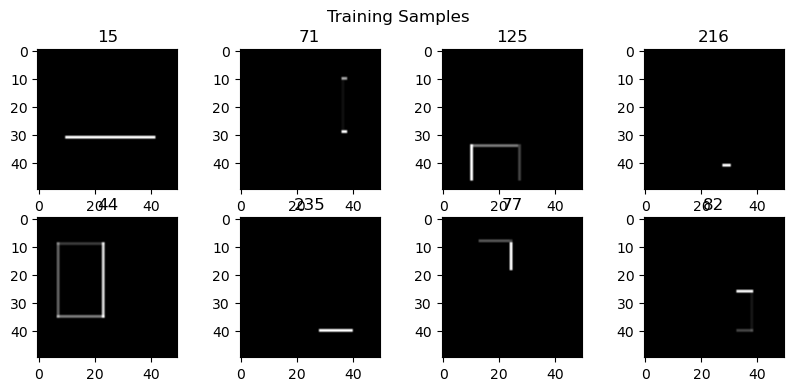

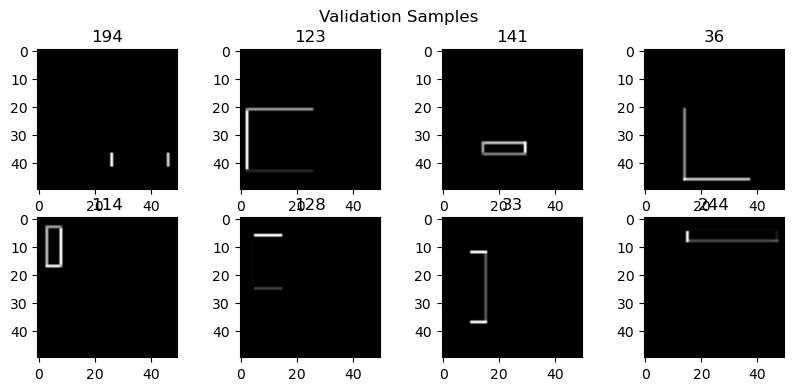

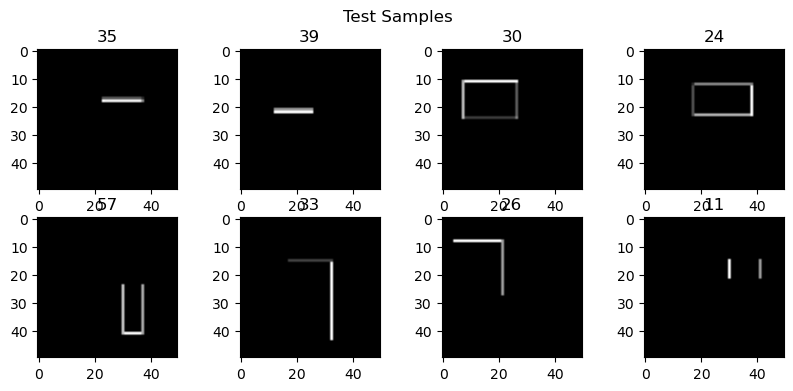

In [16]:
# Show datset samples.
showRandDataset(dataset=trainData.dataset, indices=trainData.indices, classes=trainData.dataset.classes, sample_size=8, suptitle="Training Samples")
showRandDataset(dataset=valData.dataset, indices=valData.indices, classes=valData.dataset.classes, sample_size=8, suptitle="Validation Samples")
showRandDataset(dataset=testData, indices=range(0,len(testData)), classes=testData.classes, sample_size=8, suptitle="Test Samples")


In [17]:
data_dist_report = showDataDist(trainData.dataset.classes, trainData.dataset.targets[trainData.indices], "Training set")
data_dist_report += showDataDist(valData.dataset.classes, valData.dataset.targets[valData.indices], "Validation set")
data_dist_report += showDataDist(testData.classes, testData.targets, "Test set")
# write to a file.
os.makedirs(result_dir, exist_ok=True)
with open(os.path.join(result_dir, "data_distribution.txt"), 'w') as f:
    f.write(data_dist_report)

Training set 204(1.00) : rect 204(1.00), 

Validation set 52(1.00) : rect 52(1.00), 

Test set 64(1.00) : rect 64(1.00), 



## Data Loader

In [18]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = int(np.ceil(len(trainDataLoader.dataset) / BATCH_SIZE))
valSteps = int(np.ceil(len(valDataLoader.dataset) / BATCH_SIZE))
print(f"Training steps: {trainSteps}, Validation steps: {valSteps}")

Training steps: 13, Validation steps: 4


## Model Construction

In [19]:
# initialize model
image_shape = (1,INPUT_DIM,INPUT_DIM)
layer_depth = LAYER_DEPTH
latent_dim = LATENT_DIM
model = AutoEncoder(image_shape=image_shape,
                       layer_depth=layer_depth,
                       latent_dim=latent_dim)
model_stat = summary(model, image_shape)

# write into a file.
os.makedirs(result_dir, exist_ok=True)
with open(os.path.join(result_dir, "model_summary.txt"), 'w') as f:
    f.write(model_stat.layers_to_str())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 46, 46]             832
              ReLU-2           [-1, 32, 46, 46]               0
         MaxPool2d-3           [-1, 32, 23, 23]               0
            Conv2d-4           [-1, 64, 19, 19]          51,264
              ReLU-5           [-1, 64, 19, 19]               0
         MaxPool2d-6             [-1, 64, 9, 9]               0
            Conv2d-7            [-1, 128, 5, 5]         204,928
              ReLU-8            [-1, 128, 5, 5]               0
         MaxPool2d-9            [-1, 128, 2, 2]               0
          Flatten-10                  [-1, 512]               0
           Linear-11                  [-1, 128]          65,664
           Linear-12                  [-1, 512]          66,048
        Unflatten-13            [-1, 128, 2, 2]               0
         Upsample-14            [-1, 12

AttributeError: 'NoneType' object has no attribute 'layers_to_str'

## Inferencing

/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_60251/2682655387.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


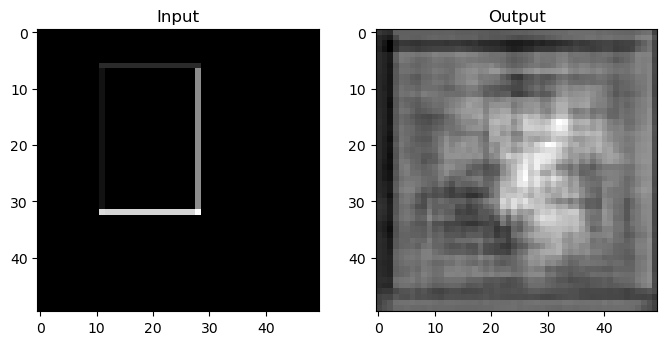

In [20]:
# Load data.
x, y_hat = testData[0]
x = x.to(DEVICE)
label_hat = testData.classes[y_hat]

# Inference.
y = model(x.unsqueeze(0))
fig = plt.figure(figsize=(8,4))
axes = fig.subplots(1,2)
ax = axes[0]
ax.imshow(x.detach().to(torch.device('cpu')).permute(1,2,0).numpy(), 'gray')
ax.set_title("Input")
ax.grid(False)
ax = axes[1]
ax.imshow(y[0].detach().to(torch.device('cpu')).detach().permute(1,2,0).numpy(), 'gray')
ax.set_title("Output")
ax.grid(False)
fig.show()

## Model Training

Choice of loss/cost function should match to the output layer of the network. In this case, we have to determine categorical cross-entropy loss. Since LeNet has LogSoftmax at the output layer then we use nn.NLLoss or negative log-likelihood. If the network has Linear at the output layer then we use nn.CrossEntropyLoss loss.

In PyTorch framework, in any training loop, we must compile the exact order:<br>
`opt.zero_grad()`<br>
`loss.backward()`<br>
`opt.step()`<br>
, before do anything else.

In [21]:
if do_train:
	# initialize our optimizer and loss function
	opt = Adam(model.parameters(), lr=INIT_LR)
	# lossFn = nn.NLLLoss() # negative log-likelihood
	lossFn = nn.MSELoss()

	# initialize a dictionary to store training history
	H = {
		"train_loss": [],
		"train_acc": [],
		"val_loss": [],
		"val_acc": []
	}

	# loop over our epochs
	for e in range(0, EPOCHS):
		# set the model in training mode
		model.train()
		# initialize the total training and validation loss
		totalTrainLoss = 0
		totalValLoss = 0
		# initialize the number of correct predictions in the training and validation step
		trainCorrect = 0
		valCorrect = 0
		# loop over the training set
		for (x, y) in trainDataLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# perform a forward pass and calculate the training loss
			pred = model(x)
			loss = lossFn(pred, x)
			# zero out the gradients, perform the backpropagation step, and update the weights
			opt.zero_grad()
			loss.backward()
			opt.step()
			# add the loss to the total training loss so far and
			totalTrainLoss += loss
	
		# switch off autograd for evaluation
		with torch.no_grad():
			# set the model in evaluation mode
			model.eval()
			# loop over the validation set
			for (x, y) in valDataLoader:
				# send the input to the device
				(x, y) = (x.to(DEVICE), y.to(DEVICE))
				# make the predictions and calculate the validation loss
				pred = model(x)
				totalValLoss += lossFn(pred, x)

		# calculate the average training and validation loss
		avgTrainLoss = totalTrainLoss / trainSteps
		avgValLoss = totalValLoss / valSteps
		# update our training history
		H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
		H["val_loss"].append(avgValLoss.cpu().detach().numpy())
		# print the model training and validation information
		print("EPOCH: {}/{}".format(e + 1, EPOCHS))
		print("Train loss: {:.6f}".format(avgTrainLoss))
		print("Val loss: {:.6f}\n".format(avgValLoss))


EPOCH: 1/10
Train loss: 0.077012
Val loss: 0.006128

EPOCH: 2/10
Train loss: 0.007289
Val loss: 0.005660

EPOCH: 3/10
Train loss: 0.007137
Val loss: 0.005660

EPOCH: 4/10
Train loss: 0.007165
Val loss: 0.005660

EPOCH: 5/10
Train loss: 0.007167
Val loss: 0.005660

EPOCH: 6/10
Train loss: 0.007100
Val loss: 0.005660

EPOCH: 7/10
Train loss: 0.007111
Val loss: 0.005660

EPOCH: 8/10
Train loss: 0.007132
Val loss: 0.005660

EPOCH: 9/10
Train loss: 0.007155
Val loss: 0.005660

EPOCH: 10/10
Train loss: 0.007129
Val loss: 0.005660



/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_60251/3097716041.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


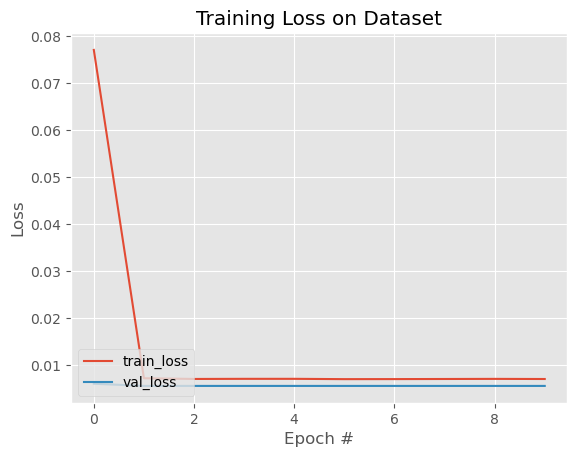

In [22]:
if do_train:
    # plot the training loss and accuracy
    # matplotlib.use("agg") # choose backend rendering engine.
    plt.style.use("ggplot")
    fig, axes = plt.subplots(1,1)
    axes.plot(H["train_loss"], label="train_loss")
    axes.plot(H["val_loss"], label="val_loss")
    axes.set_title("Training Loss on Dataset")
    axes.set_xlabel("Epoch #")
    axes.set_ylabel("Loss")
    axes.legend(loc="lower left")
    fig.show()

    # save image file.
    os.makedirs(result_dir, exist_ok=True)
    fig.savefig(os.path.join(result_dir, "history.png"))


## Saving Model

Usually we use `torch.save` to save only model states or moodel weights.


In [23]:
if do_train:
    # save model file.
    os.makedirs(model_dir, exist_ok=True)
    torch.save(model, os.path.join(model_dir, "AE.pt"))

To save together with model definition, use Just-In-Time or JIT model by `torch.jit.script` or `torch.jit.trace`, which trace model definition/handler, such as forward methods, into intermediate script that is executed during inferencing or runtime (JIT), then `torch.jit.save` to save the JIT model. See https://pytorch.org/docs/stable/jit.html#frequently-asked-questions.

JIT model remembers its original device when it is traced. As soon as you load the JIT model, it will be loaded into the orginal device.

In [24]:
if do_train:
    os.makedirs(os.path.dirname(model_dir), exist_ok=True)
    jit_model = torch.jit.script(model)
    torch.jit.save(jit_model, os.path.join(model_dir, "JIT_AE.pt"))

TypeError: 
'numpy.int64' object in attribute 'Linear.in_features' is not a valid constant.
Valid constants are:
1. a nn.ModuleList
2. a value of type {bool, float, int, str, NoneType, torch.device, torch.layout, torch.dtype}
3. a list or tuple of (2)


## Loading Model

In [25]:
# load the model and set it to evaluation mode
model = torch.load(os.path.join(model_dir, "AE.pt"))

# # load the model and set it to evaluation mode
# model = torch.jit.load(os.path.join(model_dir, "JIT_LeNet.pt"))

model.to(DEVICE)

AutoEncoder(
  (0): Encoder(
    (0): ConvLayer(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvLayer(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvLayer(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=512, out_features=128, bias=True)
  )
  (1): Decoder(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): Unflatten(dim=1, unflattened_size=[128, 2, 2])
    (2): TConvLayer(
      (0): Upsample(size=(5, 5), mode='nearest')
      (1): ConvTranspose2d(128, 64, kernel_size=(5, 5), 

## Model Evaluation

## Model Implementation

/Users/rapeewannasiri/miniconda3/envs/basex/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_60251/2828406703.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


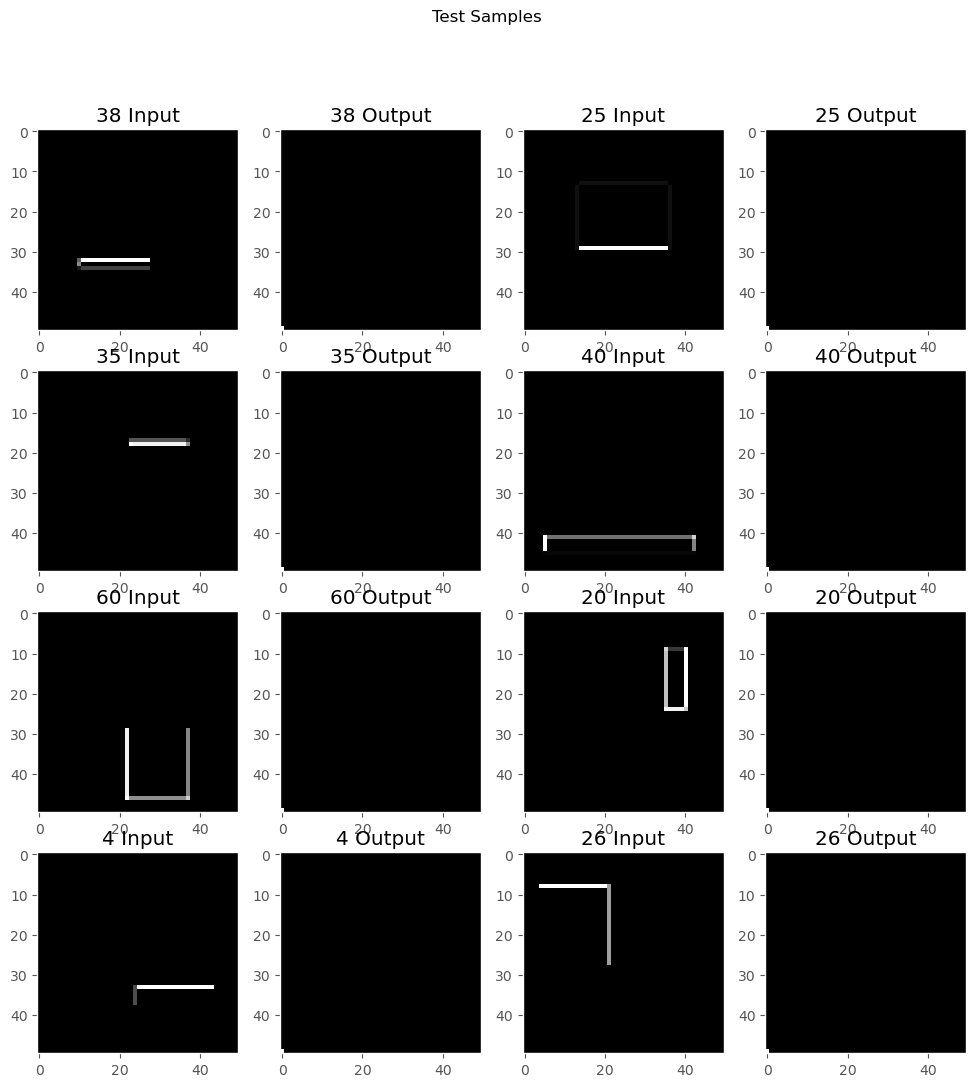

In [26]:
showRandDataset(dataset=testData, indices=range(0,len(testData)), classes=testData.classes, sample_size=8, ncols=2, figsize=(12,12), suptitle="Test Samples", model=model)